In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy
plt.style.use('seaborn')

In [2]:
#US Covid Cases
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
df.to_csv('US State Covid Cases.csv')

In [3]:
df

date          state  fips   cases  deaths
0      2020-01-21     Washington    53       1       0
1      2020-01-22     Washington    53       1       0
2      2020-01-23     Washington    53       1       0
3      2020-01-24       Illinois    17       1       0
4      2020-01-24     Washington    53       1       0
...           ...            ...   ...     ...     ...
23549  2021-05-04       Virginia    51  662696   10823
23550  2021-05-04     Washington    53  410494    5575
23551  2021-05-04  West Virginia    54  154551    2695
23552  2021-05-04      Wisconsin    55  663105    7582
23553  2021-05-04        Wyoming    56   58367     710

[23554 rows x 5 columns]

In [4]:
## Data Schema: https://docs.safegraph.com/docs/social-distancing-metrics

In [5]:
#df1 = pd.read_csv('social_distancing.csv',index_col=0)

In [6]:
#use new dataset
df1 = pd.read_csv('social_distancing_all_dates.csv',index_col=0)

In [7]:
df1.head()

origin_census_block_group           date_range_start  \
0               360470064002  2019-01-01T00:00:00-05:00   
1               360810384001  2019-01-01T00:00:00-05:00   
2               360850170103  2019-01-01T00:00:00-05:00   
3               360050177022  2019-01-01T00:00:00-05:00   
4               360050248002  2019-01-01T00:00:00-05:00   

              date_range_end  device_count  distance_traveled_from_home  \
0  2019-01-02T00:00:00-05:00            60                        620.0   
1  2019-01-02T00:00:00-05:00           105                       2253.0   
2  2019-01-02T00:00:00-05:00           199                       1952.0   
3  2019-01-02T00:00:00-05:00            85                       1859.0   
4  2019-01-02T00:00:00-05:00            51                        428.0   

                          bucketed_distance_traveled  \
0  {"16001-50000":7,"0":25,">50000":1,"2001-8000"...   
1  {"16001-50000":3,"0":55,">50000":2,"2001-8000"...   
2  {"16001-50000":14,"0":88,">50000":11,"2001-800...   
3  {"16001-50000":1,"0":46,"2001-8000":10,"1-1000...   
4  {"16001-50000":1,"0":27,"2001-8000":9,"1-1000"...   

          median_dwell_at_bucketed_distance_traveled  \
0  {"16001-50000":77,">50000":1086,"<1000":38,"20...   
1  {"16001-50000":153,">50000":338,"<1000":264,"2...   
2  {"16001-50000":82,">50000":82,"<1000":258,"200...   
3  {"16001-50000":679,"<1000":205,"2001-8000":231...   
4  {"16001-50000":21,"<1000":188,"2001-8000":145,...   

   completely_home_device_count  median_home_dwell_time  \
0                            29                     795   
1                            55                     910   
2                            89                     984   
3                            45                     638   
4                            30                     487   

                            bucketed_home_dwell_time  ... distance_traveled:0  \
0  {"721-1080":6,"361-720":9,"61-360":13,"<60":8,...  ...                25.0   
1  {"721-1080":13,"361-720":10,"61-360":17,"<60":...  ...                55.0   
2  {"721-1080":32,"361-720":19,"61-360":26,"<60":...  ...                88.0   
3  {"721-1080":14,"361-720":11,"61-360":14,"<60":...  ...                46.0   
4  {"721-1080":5,"361-720":6,"61-360":12,"<60":10...  ...                27.0   

   distance_traveled:2001-8000  distance_traveled:1-1000  \
0                          1.0                      14.0   
1                         17.0                       8.0   
2                         39.0                      10.0   
3                         10.0                       8.0   
4                          9.0                       3.0   

  distance_traveled:1001-2000  distance_traveled:8001-16000  \
0                         3.0                           4.0   
1                         2.0                           2.0   
2                        13.0                          17.0   
3                         6.0                           3.0   
4                         4.0                           2.0   

   home_dwell_time:721-1080  home_dwell_time:361-720 home_dwell_time:61-360  \
0                       6.0                      9.0                   13.0   
1                      13.0                     10.0                   17.0   
2                      32.0                     19.0                   26.0   
3                      14.0                     11.0                   14.0   
4                       5.0                      6.0                   12.0   

   home_dwell_time:<60 home_dwell_time:>1080  
0                  8.0                  23.0  
1                 15.0                  43.0  
2                 33.0                  87.0  
3                 17.0                  29.0  
4                 10.0                  18.0  

[5 rows x 34 columns]

In [8]:
check1 = df1['date_range_start']
check1.to_csv('check1.csv')

In [9]:
df1.shape

(5244691, 34)

In [10]:
df1.columns

Index(['origin_census_block_group', 'date_range_start', 'date_range_end',
       'device_count', 'distance_traveled_from_home',
       'bucketed_distance_traveled',
       'median_dwell_at_bucketed_distance_traveled',
       'completely_home_device_count', 'median_home_dwell_time',
       'bucketed_home_dwell_time', 'at_home_by_each_hour',
       'part_time_work_behavior_devices', 'full_time_work_behavior_devices',
       'destination_cbgs', 'delivery_behavior_devices',
       'median_non_home_dwell_time', 'candidate_device_count',
       'bucketed_away_from_home_time', 'median_percentage_time_home',
       'bucketed_percentage_time_home', 'mean_home_dwell_time',
       'mean_non_home_dwell_time', 'mean_distance_traveled_from_home',
       'distance_traveled:16001-50000', 'distance_traveled:0',
       'distance_traveled:2001-8000', 'distance_traveled:1-1000',
       'distance_traveled:1001-2000', 'distance_traveled:8001-16000',
       'home_dwell_time:721-1080', 'home_dwell_time:361-72

In [11]:
df1[['date_range_start','date_range_end']].dtypes

date_range_start    object
date_range_end      object
dtype: object

In [12]:
df1['date'] = df1['date_range_start'].str[:10]
df1['date'] = pd.to_datetime(df1['date'])
df1['year'] = df1['date'].dt.year
dfnew = df1[['date','device_count'
            ,'mean_distance_traveled_from_home'
            ,'mean_home_dwell_time'
            ,'completely_home_device_count'
            ,'part_time_work_behavior_devices'
            ,'full_time_work_behavior_devices'
            ,'delivery_behavior_devices'
            ,'distance_traveled:0'
            ,'distance_traveled:1-1000'
            ,'distance_traveled:1001-2000'
            ,'distance_traveled:2001-8000'
            ,'distance_traveled:8001-16000'
            ,'distance_traveled:16001-50000'
            ,'home_dwell_time:<60'
            ,'home_dwell_time:61-360'
            ,'home_dwell_time:361-720'
            ,'home_dwell_time:721-1080'
            ,'home_dwell_time:>1080'
           ]].groupby('date').sum()
dfnew

device_count  mean_distance_traveled_from_home  \
date                                                         
2019-01-01        546548                        75683277.0   
2019-01-02        548629                        56568701.0   
2019-01-03        541106                        53521466.0   
2019-01-04        546201                        50083722.0   
2019-01-05        548061                        58048382.0   
...                  ...                               ...   
2021-04-12        290498                        56850655.0   
2021-04-13        276410                        43155541.0   
2021-04-14        279518                        47064636.0   
2021-04-15        268208                        59541129.0   
2021-04-16        271090                        59184317.0   

            mean_home_dwell_time  completely_home_device_count  \
date                                                             
2019-01-01             4400074.0                        256262   
2019-01-02             3996661.0                        220643   
2019-01-03             3963868.0                        206784   
2019-01-04             3897095.0                        204272   
2019-01-05             4427800.0                        255867   
...                          ...                           ...   
2021-04-12             4575311.0                        106032   
2021-04-13             4518380.0                         97626   
2021-04-14             4462034.0                         94449   
2021-04-15             4546690.0                        131965   
2021-04-16             4304721.0                         91877   

            part_time_work_behavior_devices  full_time_work_behavior_devices  \
date                                                                           
2019-01-01                            16497                             9962   
2019-01-02                            40825                            31620   
2019-01-03                            44356                            33526   
2019-01-04                            47753                            33817   
2019-01-05                            22774                            11594   
...                                     ...                              ...   
2021-04-12                            17377                            14746   
2021-04-13                            20138                            17036   
2021-04-14                            19299                            15446   
2021-04-15                            13000                            12028   
2021-04-16                            21734                            16892   

            delivery_behavior_devices  distance_traveled:0  \
date                                                         
2019-01-01                      10842             244343.0   
2019-01-02                      14374             209599.0   
2019-01-03                      14261             196505.0   
2019-01-04                      17197             194694.0   
2019-01-05                      13148             241816.0   
...                               ...                  ...   
2021-04-12                       9537              92740.0   
2021-04-13                      11730              82381.0   
2021-04-14                      10585              82657.0   
2021-04-15                       9608             101941.0   
2021-04-16                      13408              79030.0   

            distance_traveled:1-1000  distance_traveled:1001-2000  \
date                                                                
2019-01-01                   64164.0                      30695.0   
2019-01-02                   64891.0                      33215.0   
2019-01-03                   63991.0                      32759.0   
2019-01-04                   65782.0                      34618.0   
2019-01-05                   63669.0                      30264.0   
...            

In [13]:
#check2
check2 = dfnew.reset_index()
check2 = check2['date']
check2.to_csv('check2.csv')

In [14]:
dfnew = dfnew.reset_index()
dfnew['year'] = dfnew.date.dt.year
dfnew.set_index('date',inplace=True)
dfnew

device_count  mean_distance_traveled_from_home  \
date                                                         
2019-01-01        546548                        75683277.0   
2019-01-02        548629                        56568701.0   
2019-01-03        541106                        53521466.0   
2019-01-04        546201                        50083722.0   
2019-01-05        548061                        58048382.0   
...                  ...                               ...   
2021-04-12        290498                        56850655.0   
2021-04-13        276410                        43155541.0   
2021-04-14        279518                        47064636.0   
2021-04-15        268208                        59541129.0   
2021-04-16        271090                        59184317.0   

            mean_home_dwell_time  completely_home_device_count  \
date                                                             
2019-01-01             4400074.0                        256262   
2019-01-02             3996661.0                        220643   
2019-01-03             3963868.0                        206784   
2019-01-04             3897095.0                        204272   
2019-01-05             4427800.0                        255867   
...                          ...                           ...   
2021-04-12             4575311.0                        106032   
2021-04-13             4518380.0                         97626   
2021-04-14             4462034.0                         94449   
2021-04-15             4546690.0                        131965   
2021-04-16             4304721.0                         91877   

            part_time_work_behavior_devices  full_time_work_behavior_devices  \
date                                                                           
2019-01-01                            16497                             9962   
2019-01-02                            40825                            31620   
2019-01-03                            44356                            33526   
2019-01-04                            47753                            33817   
2019-01-05                            22774                            11594   
...                                     ...                              ...   
2021-04-12                            17377                            14746   
2021-04-13                            20138                            17036   
2021-04-14                            19299                            15446   
2021-04-15                            13000                            12028   
2021-04-16                            21734                            16892   

            delivery_behavior_devices  distance_traveled:0  \
date                                                         
2019-01-01                      10842             244343.0   
2019-01-02                      14374             209599.0   
2019-01-03                      14261             196505.0   
2019-01-04                      17197             194694.0   
2019-01-05                      13148             241816.0   
...                               ...                  ...   
2021-04-12                       9537              92740.0   
2021-04-13                      11730              82381.0   
2021-04-14                      10585              82657.0   
2021-04-15                       9608             101941.0   
2021-04-16                      13408              79030.0   

            distance_traveled:1-1000  distance_traveled:1001-2000  \
date                                                                
2019-01-01                   64164.0                      30695.0   
2019-01-02                   64891.0                      33215.0   
2019-01-03                   63991.0                      32759.0   
2019-01-04                   65782.0                      34618.0   
2019-01-05                   63669.0                      30264.0   
...            

## 1. Device Analysis

In [15]:
df_d = dfnew[['device_count','completely_home_device_count','part_time_work_behavior_devices','full_time_work_behavior_devices','delivery_behavior_devices','year']]
df_d.describe()

device_count  completely_home_device_count  \
count     837.000000                    837.000000   
mean   403473.132616                 149614.826762   
std    100393.607464                  41388.107537   
min    225361.000000                  66163.000000   
25%    322471.000000                 117114.000000   
50%    367628.000000                 143435.000000   
75%    498853.000000                 177242.000000   
max    619927.000000                 304506.000000   

       part_time_work_behavior_devices  full_time_work_behavior_devices  \
count                       837.000000                       837.000000   
mean                      27667.120669                     19457.860215   
std                       14554.546400                     11045.732650   
min                        7845.000000                      6927.000000   
25%                       15887.000000                     10704.000000   
50%                       20728.000000                     14490.000000   
75%                       42227.000000                     30366.000000   
max                       61607.000000                     45581.000000   

       delivery_behavior_devices         year  
count                 837.000000   837.000000  
mean                13551.494624  2019.690562  
std                  3840.715393     0.683762  
min                  7093.000000  2019.000000  
25%                 10160.000000  2019.000000  
50%                 12676.000000  2020.000000  
75%                 16858.000000  2020.000000  
max                 22887.000000  2021.000000

Text(0.5, 1.0, 'Prediction of working device')

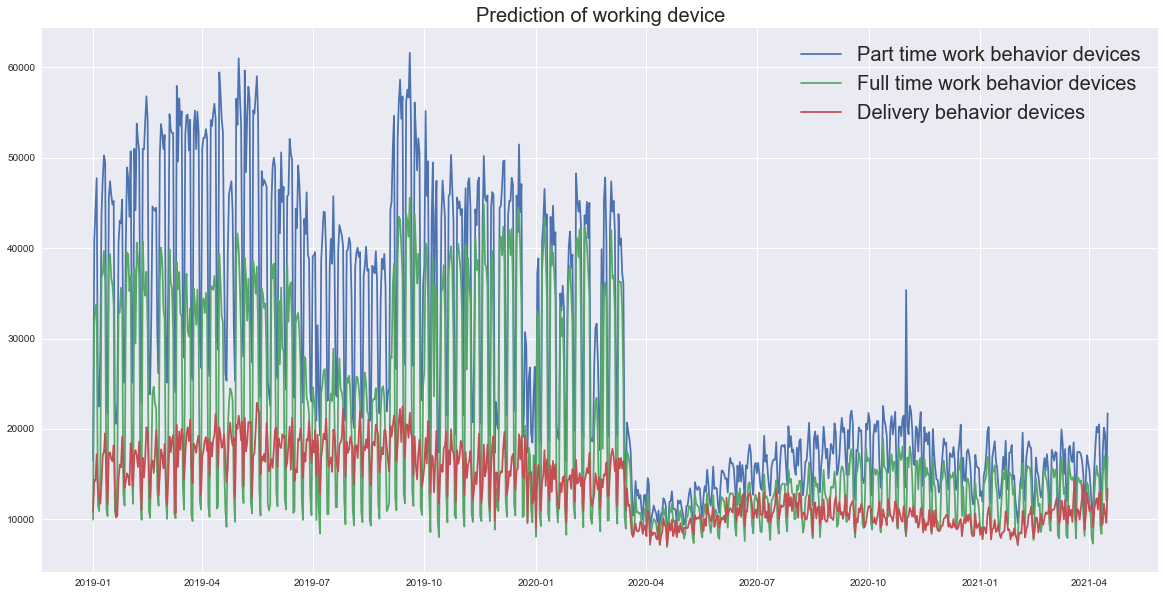

In [16]:
plt.figure(figsize=(20,10))
plt.plot(df_d[['part_time_work_behavior_devices','full_time_work_behavior_devices','delivery_behavior_devices']])
plt.legend(['Part time work behavior devices','Full time work behavior devices','Delivery behavior devices'],fontsize=20)
plt.title("Prediction of working device", fontsize=20)

Text(0.5, 1.0, 'Working device Count(moving average=30)')

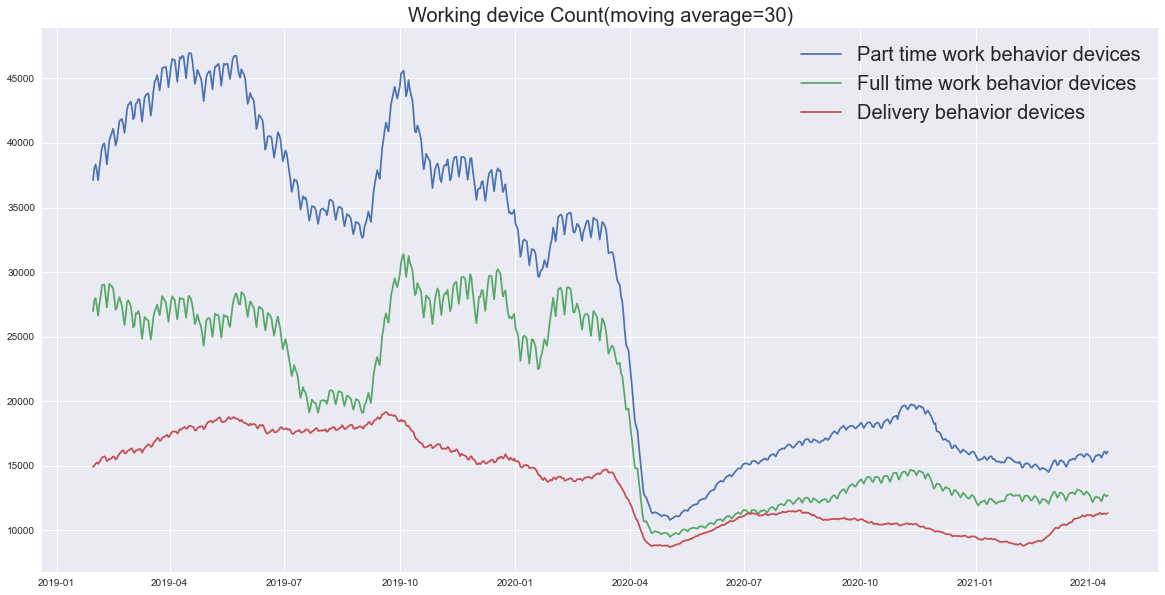

In [17]:
plt.figure(figsize=(20,10))
plt.plot(df_d[['part_time_work_behavior_devices','full_time_work_behavior_devices','delivery_behavior_devices']].rolling(window=30).mean())
plt.legend(['Part time work behavior devices','Full time work behavior devices','Delivery behavior devices'],fontsize=20)
plt.title("Working device Count(moving average=30)", fontsize=20)

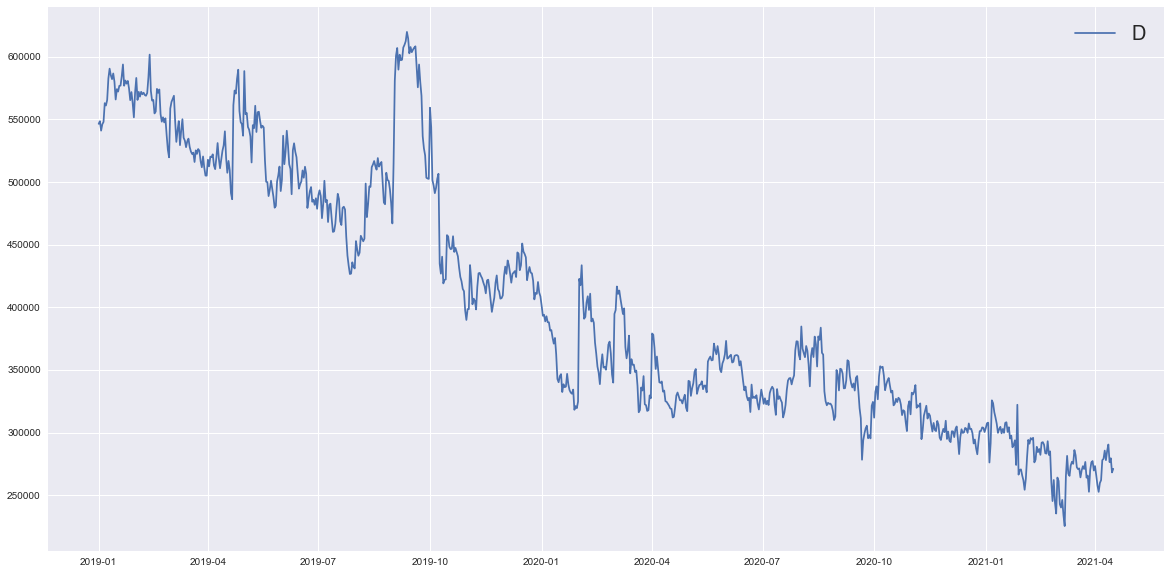

In [18]:
plt.figure(figsize=(20,10))
plt.plot(df_d['device_count'])
plt.legend('Di',fontsize=20)

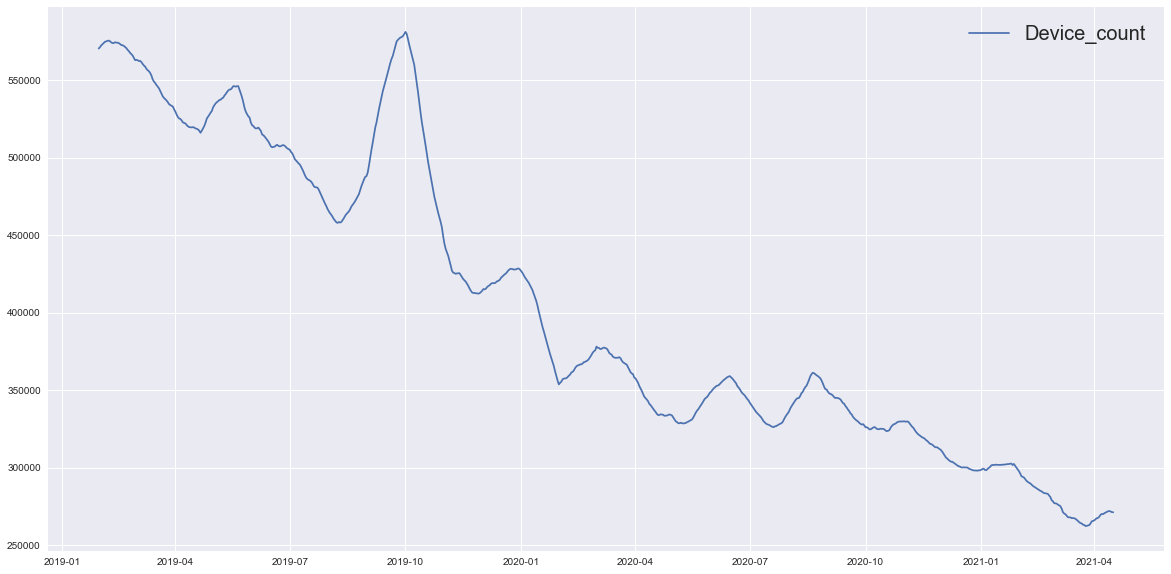

In [19]:
plt.figure(figsize=(20,10))
plt.plot(df_d['device_count'].rolling(window=30).mean())
plt.legend(['Device_count'],fontsize=20)

In [20]:
df_d

device_count  completely_home_device_count  \
date                                                     
2019-01-01        546548                        256262   
2019-01-02        548629                        220643   
2019-01-03        541106                        206784   
2019-01-04        546201                        204272   
2019-01-05        548061                        255867   
...                  ...                           ...   
2021-04-12        290498                        106032   
2021-04-13        276410                         97626   
2021-04-14        279518                         94449   
2021-04-15        268208                        131965   
2021-04-16        271090                         91877   

            part_time_work_behavior_devices  full_time_work_behavior_devices  \
date                                                                           
2019-01-01                            16497                             9962   
2019-01-02                            40825                            31620   
2019-01-03                            44356                            33526   
2019-01-04                            47753                            33817   
2019-01-05                            22774                            11594   
...                                     ...                              ...   
2021-04-12                            17377                            14746   
2021-04-13                            20138                            17036   
2021-04-14                            19299                            15446   
2021-04-15                            13000                            12028   
2021-04-16                            21734                            16892   

            delivery_behavior_devices  year  
date                                         
2019-01-01                      10842  2019  
2019-01-02                      14374  2019  
2019-01-03                      14261  2019  
2019-01-04                      17197  2019  
2019-01-05                      13148  2019  
...                               ...   ...  
2021-04-12                       9537  2021  
2021-04-13                      11730  2021  
2021-04-14                      10585  2021  
2021-04-15                       9608  2021  
2021-04-16                      13408  2021  

[837 rows x 6 columns]

In [21]:
series=df_d['device_count']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.564516
p-value: 0.501389
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [22]:
#reaches the stationarity after first differencing
result = adfuller(series.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.330211
p-value: 0.000000


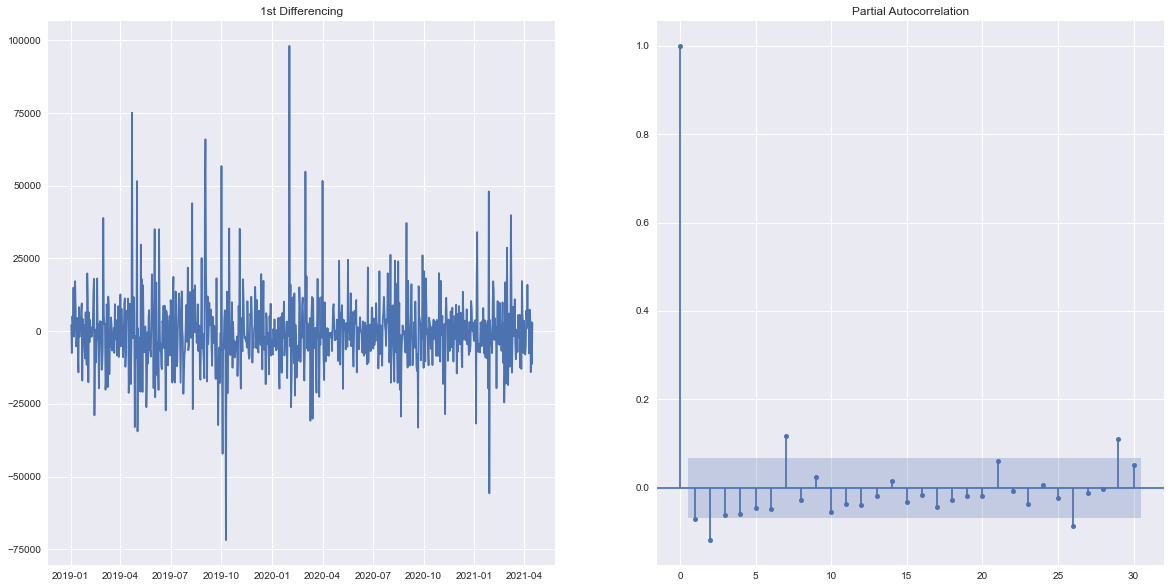

In [23]:
#AR
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].plot(series.diff())
axes[0].set_title('1st Differencing')

plot_pacf(series.diff().dropna(), ax=axes[1])

plt.show()

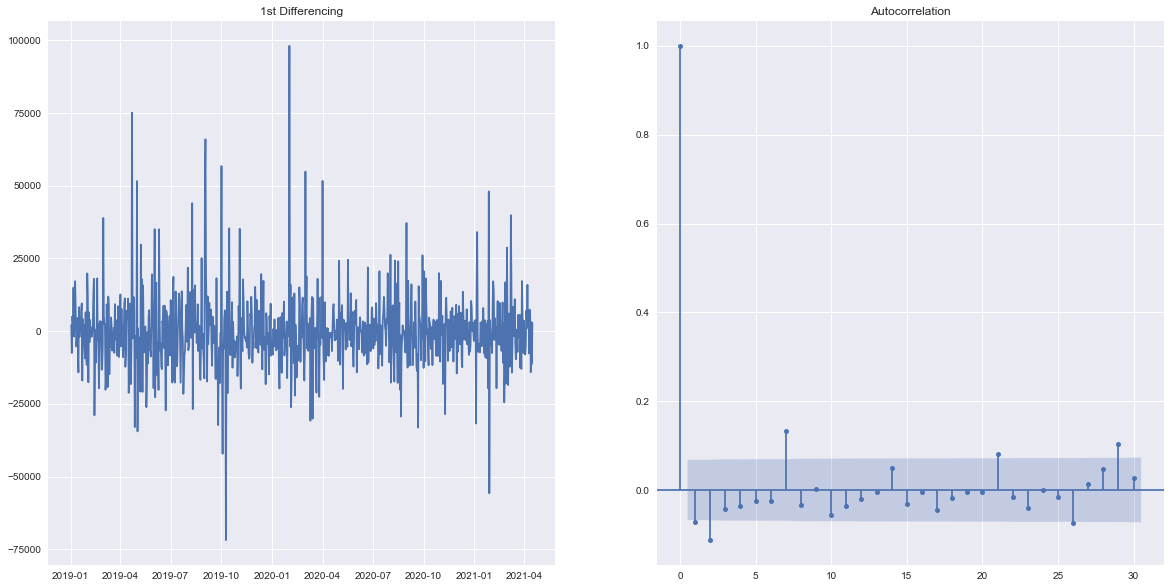

In [24]:
#MA
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].plot(series.diff()); axes[0].set_title('1st Differencing')
plot_acf(series.diff().dropna(), ax=axes[1],alpha=0.05)

plt.show()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:         D.device_count   No. Observations:                  669
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7290.678
Method:                       css-mle   S.D. of innovations          13079.824
Date:                Mon, 03 May 2021   AIC                          14593.357
Time:                        14:46:55   BIC                          14620.392
Sample:                    01-02-2019   HQIC                         14603.829
                         - 10-31-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -346.7593    344.244     -1.007      0.314   -1021.465     327.946
ar.L1.D.device_count    -0.2238      0.169     -1.323      0.186      -0.556       0.108
ar.L2.D.devi

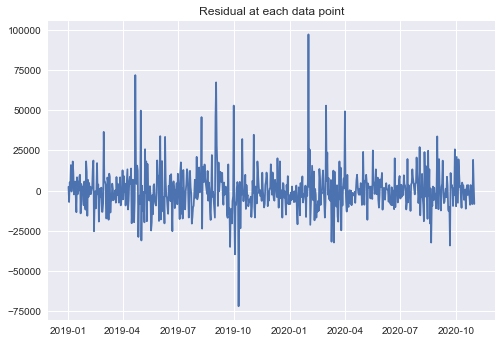

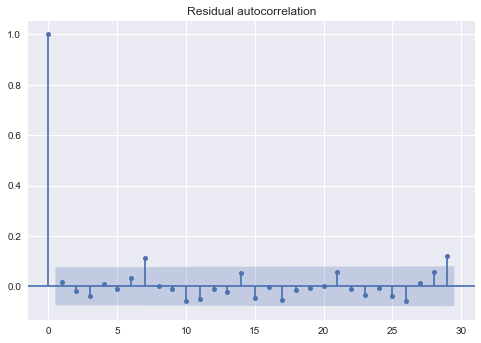

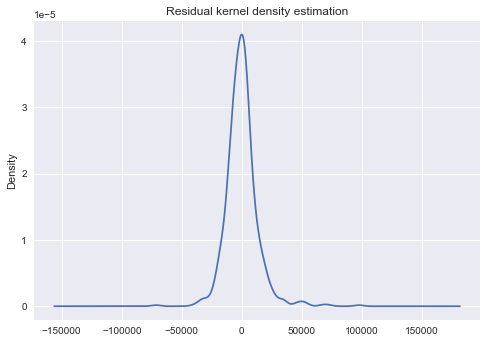

                  0
count    669.000000
mean       1.772718
std    13090.131501
min   -71824.616455
25%    -7106.794260
50%     -691.874581
75%     4993.673548
max    97186.779755
p value is  4.6055353305090076e-52
null hypothesis: residuals comes from a normal distribution
The null hypothesis can be rejected


In [25]:
P=2
D=1
Q=2

# fit model
N= 670
model = ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit(disp = 0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# plt.figure(figsize = (6,4))
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals comes from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [26]:
model_fit.aic

14593.35695086413

Text(0.5, 1.0, 'Prediction of working device count')

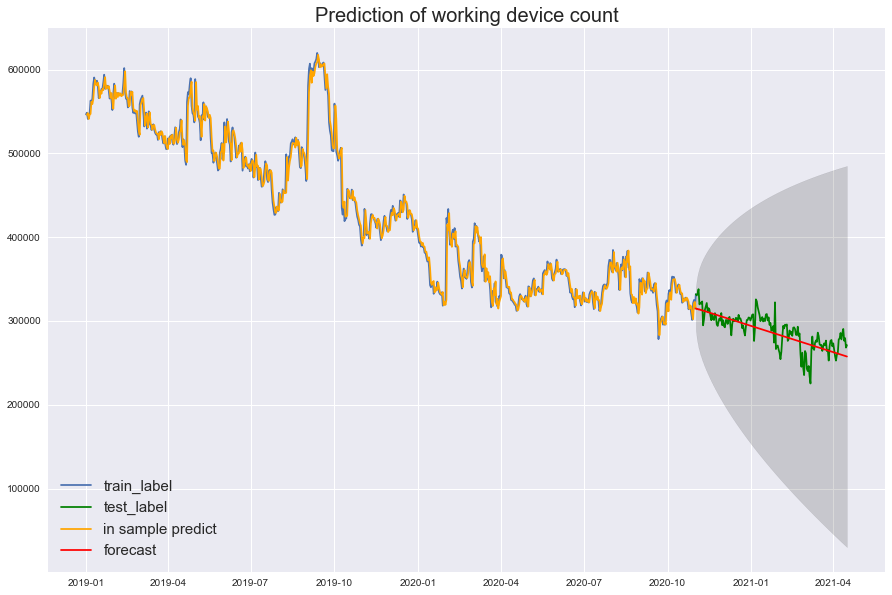

In [27]:
forecast = model_fit.forecast(steps=len(series)-N, alpha=0.05)[0]  # 95% conf
# Forecast
fc, se, conf = model_fit.forecast(steps=len(series)-N, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=range(N,len(series)))
lower_series = pd.Series(conf[:, 0], index=range(N,len(series)))
upper_series = pd.Series(conf[:, 1], index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(15,10)})
# plt.plot(series)

# plt.plot(series)
plt.plot(df_d.index[:N+1],series[:N+1],label='train_label')
plt.plot(df_d.index[N:],series[N:],color='green',label='test_label')
plt.plot(df_d.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),color='orange',label='in sample predict')
plt.plot(df_d.iloc[N:].index,fc_series.tolist(), label='forecast', color='red')
plt.fill_between(df_d.iloc[N:].index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='lower left',fontsize=15)
plt.title("Prediction of working device count", fontsize=20)

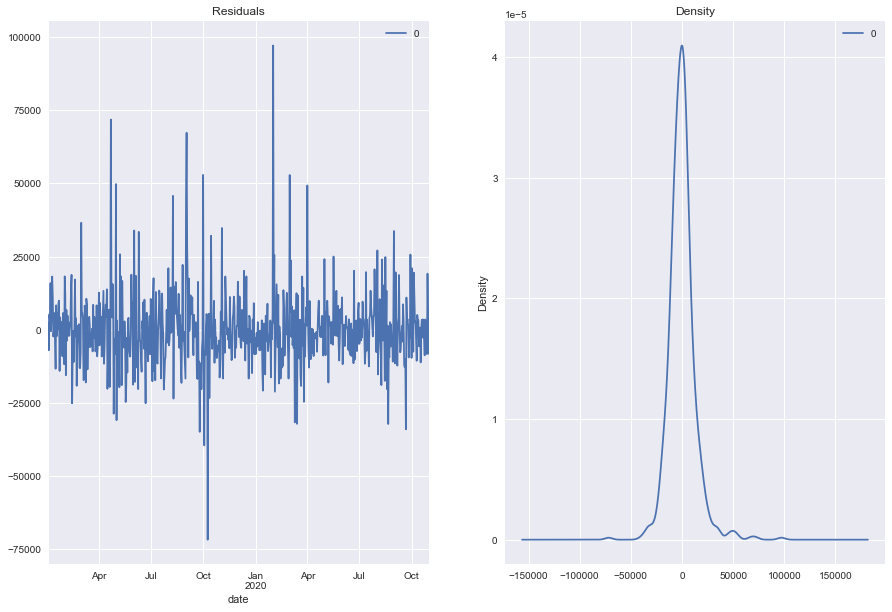

In [28]:
##Check the residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


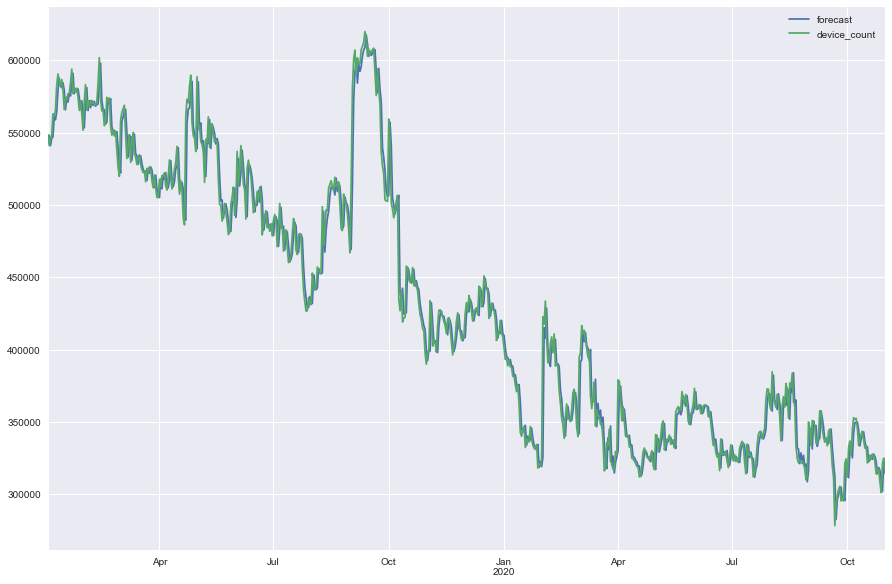

In [29]:
## bar chart
model_fit.plot_predict(dynamic=False)
plt.show()

## Travel Distance

In [30]:
df_t = dfnew[['mean_distance_traveled_from_home',
              'distance_traveled:16001-50000', 'distance_traveled:0',
              'distance_traveled:2001-8000', 'distance_traveled:1-1000',
              'distance_traveled:1001-2000', 'distance_traveled:8001-16000']]
df_t.describe()


mean_distance_traveled_from_home  distance_traveled:16001-50000  \
count                      8.370000e+02                     837.000000   
mean                       4.466440e+07                   37035.231780   
std                        2.344703e+07                    5915.369698   
min                        0.000000e+00                   25002.000000   
25%                        3.706644e+07                   32397.000000   
50%                        4.754166e+07                   35758.000000   
75%                        5.689680e+07                   41974.000000   
max                        1.297235e+08                   59936.000000   

       distance_traveled:0  distance_traveled:2001-8000  \
count           837.000000                   837.000000   
mean         136622.247312                 71754.612903   
std           40813.663513                 25148.865797   
min           64780.000000                 31661.000000   
25%          104453.000000                 49571.000000   
50%          131404.000000                 67870.000000   
75%          161968.000000                 93658.000000   
max          289274.000000                135599.000000   

       distance_traveled:1-1000  distance_traveled:1001-2000  \
count                837.000000                   837.000000   
mean               52393.657109                 28098.896057   
std                11918.951279                  5657.964092   
min                29462.000000                 15586.000000   
25%                42586.000000                 23311.000000   
50%                50536.000000                 27842.000000   
75%                63494.000000                 32607.000000   
max                77024.000000                 41384.000000   

       distance_traveled:8001-16000  
count                    837.000000  
mean                   37529.493429  
std                    15387.044451  
min                    14102.000000  
25%                    24149.000000  
50%                    32146.000000  
75%                    50918.000000  
max                    75556.000000

Text(0.5, 1.0, 'Travel distance count')

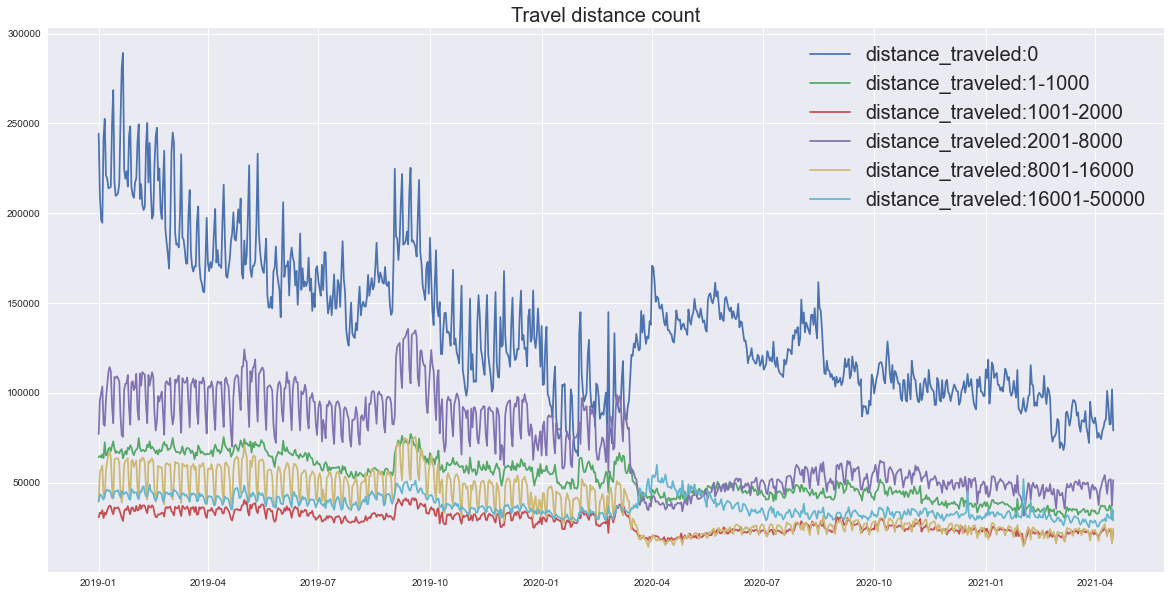

In [31]:
plt.figure(figsize=(20,10))
plt.style.use('seaborn')
plt.plot(df_t[['distance_traveled:0'
               ,'distance_traveled:1-1000'
               ,'distance_traveled:1001-2000'
               ,'distance_traveled:2001-8000'
               ,'distance_traveled:8001-16000'
               ,'distance_traveled:16001-50000']])
plt.legend(['distance_traveled:0'
               ,'distance_traveled:1-1000'
               ,'distance_traveled:1001-2000'
               ,'distance_traveled:2001-8000'
               ,'distance_traveled:8001-16000'
               ,'distance_traveled:16001-50000'],fontsize=20)
plt.title("Travel distance count", fontsize=20)

Text(0.5, 1.0, 'Travel distance count(moving average = 30)')

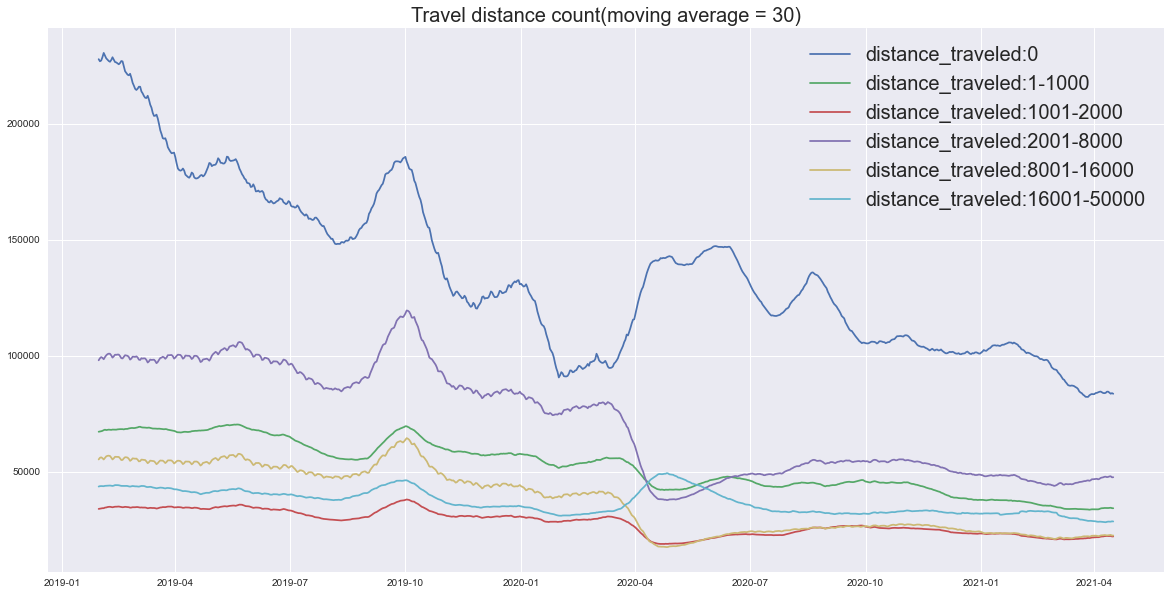

In [32]:
plt.figure(figsize=(20,10))
plt.style.use('seaborn')
plt.plot(df_t[['distance_traveled:0'
               ,'distance_traveled:1-1000'
               ,'distance_traveled:1001-2000'
               ,'distance_traveled:2001-8000'
               ,'distance_traveled:8001-16000'
               ,'distance_traveled:16001-50000'
               ]].rolling(window=30).mean())
plt.legend(['distance_traveled:0'
               ,'distance_traveled:1-1000'
               ,'distance_traveled:1001-2000'
               ,'distance_traveled:2001-8000'
               ,'distance_traveled:8001-16000'
               ,'distance_traveled:16001-50000'],fontsize=20)
plt.title("Travel distance count(moving average = 30)", fontsize=20)

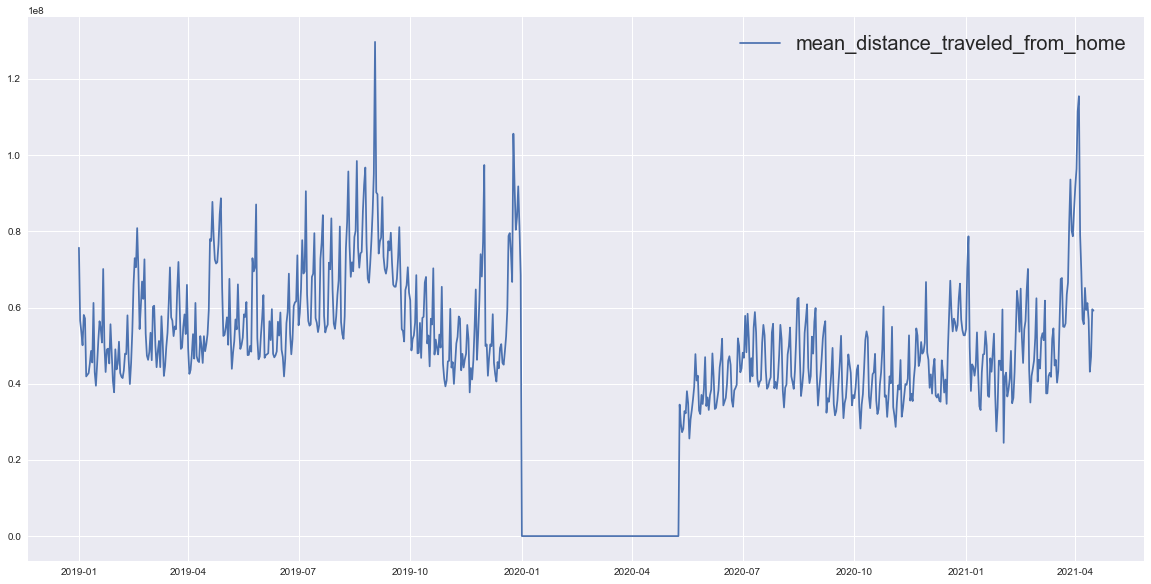

In [33]:
# The original mean travel distance contains missing value for 3 months
plt.figure(figsize=(20,10))
plt.plot(df_t['mean_distance_traveled_from_home'])
plt.legend(['mean_distance_traveled_from_home'],fontsize=20)

In [34]:
ff = []
ffm = df_t['distance_traveled:1-1000']*500+df_t['distance_traveled:1001-2000']*1500+df_t['distance_traveled:2001-8000']*5000+df_t['distance_traveled:8001-16000']*12000+df_t['distance_traveled:16001-50000']*33000
ffd = df_t['distance_traveled:0']+df_t['distance_traveled:1-1000']+df_t['distance_traveled:1001-2000']+df_t['distance_traveled:2001-8000']+df_t['distance_traveled:8001-16000']+df_t['distance_traveled:16001-50000']
ff = ffm/ffd
df_t[['tmeans']] = ff
df_t

mean_distance_traveled_from_home  distance_traveled:16001-50000  \
date                                                                          
2019-01-01                        75683277.0                          39684   
2019-01-02                        56568701.0                          43386   
2019-01-03                        53521466.0                          42958   
2019-01-04                        50083722.0                          41729   
2019-01-05                        58048382.0                          40532   
...                                      ...                            ...   
2021-04-12                        56850655.0                          31362   
2021-04-13                        43155541.0                          30196   
2021-04-14                        47064636.0                          30185   
2021-04-15                        59541129.0                          35509   
2021-04-16                        59184317.0                          28830   

            distance_traveled:0  distance_traveled:2001-8000  \
date                                                           
2019-01-01             244343.0                      76978.0   
2019-01-02             209599.0                      95996.0   
2019-01-03             196505.0                      99844.0   
2019-01-04             194694.0                     103522.0   
2019-01-05             241816.0                      82630.0   
...                         ...                          ...   
2021-04-12              92740.0                      50826.0   
2021-04-13              82381.0                      51705.0   
2021-04-14              82657.0                      51854.0   
2021-04-15             101941.0                      37103.0   
2021-04-16              79030.0                      51406.0   

            distance_traveled:1-1000  distance_traveled:1001-2000  \
date                                                                
2019-01-01                   64164.0                      30695.0   
2019-01-02                   64891.0                      33215.0   
2019-01-03                   63991.0                      32759.0   
2019-01-04                   65782.0                      34618.0   
2019-01-05                   63669.0                      30264.0   
...                              ...                          ...   
2021-04-12                   34624.0                      22572.0   
2021-04-13                   37330.0                      23653.0   
2021-04-14                   36746.0                      23649.0   
2021-04-15                   29462.0                      16984.0   
2021-04-16                   34191.0                      22790.0   

            distance_traveled:8001-16000       tmeans  
date                                                   
2019-01-01                       39146.0  4529.885255  
2019-01-02                       56001.0  5299.267723  
2019-01-03                       57768.0  5449.671442  
2019-01-04                       59456.0  5388.058447  
2019-01-05                       42697.0  4665.596442  
...                                  ...          ...  
2021-04-12                       24149.0  6360.537396  
2021-04-13                       24179.0  6411.400956  
2021-04-14                       24398.0  6421.114759  
2021-04-15                       16099.0  6709.069667  
2021-04-16                       24311.0  6449.307444  

[837 rows x 8 columns]

Text(0.5, 1.0, 'Mean travel distance')

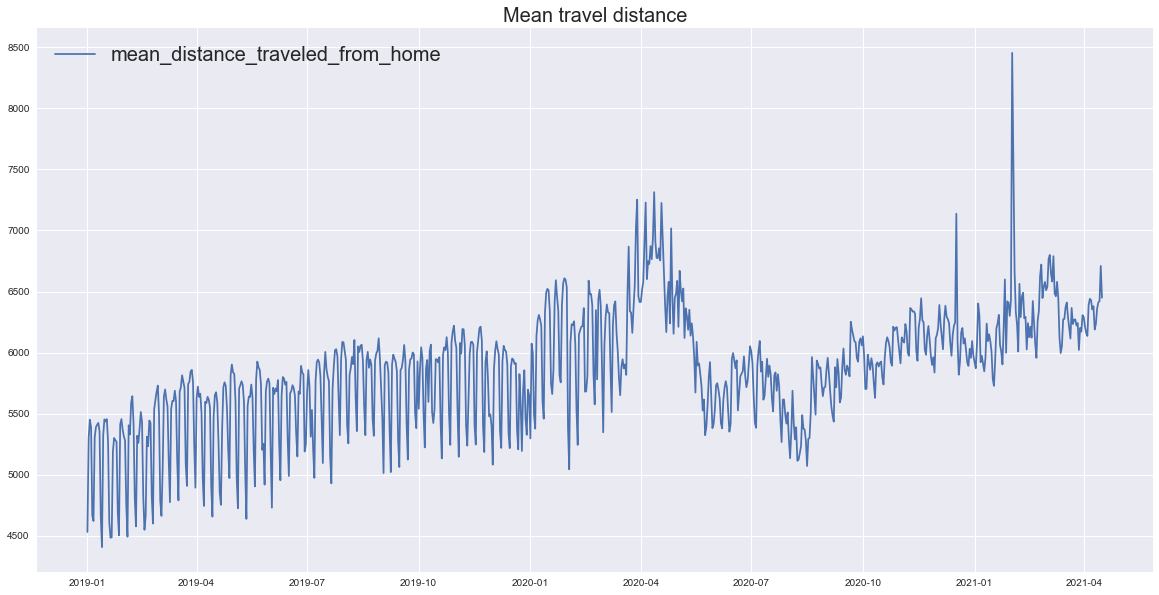

In [35]:
plt.figure(figsize=(20,10))
plt.plot(df_t['tmeans'])
plt.legend(['mean_distance_traveled_from_home'],fontsize=20)
plt.title("Mean travel distance", fontsize=20)

Text(0.5, 1.0, 'Mean travel distance(moving average = 30)')

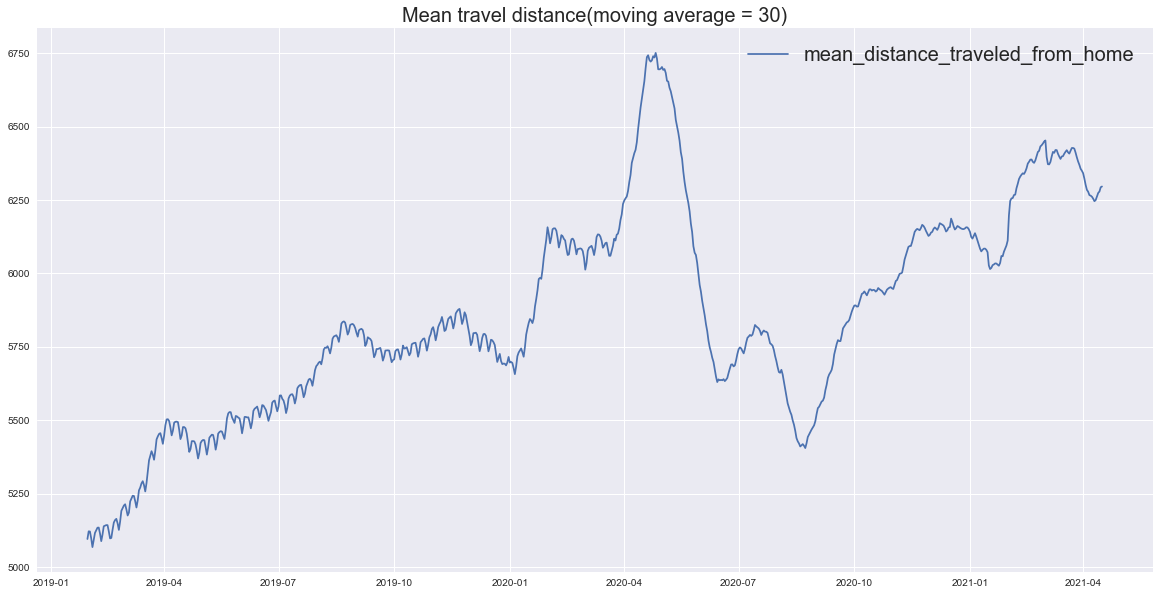

In [36]:
plt.figure(figsize=(20,10))
plt.plot(df_t['tmeans'].rolling(window=30).mean())
plt.legend(['mean_distance_traveled_from_home'],fontsize=20)
plt.title("Mean travel distance(moving average = 30)", fontsize=20)

In [37]:
series=df_t['tmeans']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.440750
p-value: 0.130564
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [38]:
#reaches the stationarity after first differencing
result = adfuller(series.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.276812
p-value: 0.000000


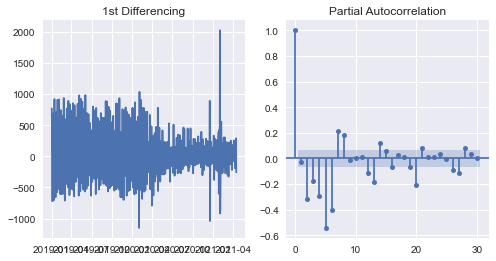

In [39]:
#AR
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].plot(series.diff())
axes[0].set_title('1st Differencing')

plot_pacf(series.diff().dropna(), ax=axes[1])

plt.show()

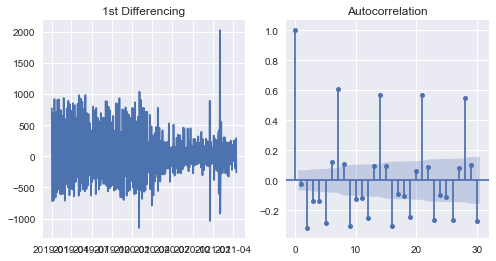

In [40]:
#MA
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].plot(series.diff()); axes[0].set_title('1st Differencing')
plot_acf(series.diff().dropna(), ax=axes[1],alpha=0.05)

plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D.tmeans   No. Observations:                  752
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5415.167
Method:                           css   S.D. of innovations            324.434
Date:                Mon, 03 May 2021   AIC                          10834.334
Time:                        14:46:58   BIC                          10843.580
Sample:                    01-02-2019   HQIC                         10837.896
                         - 01-22-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0395     11.831      0.172      0.863     -21.149      25.228


D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


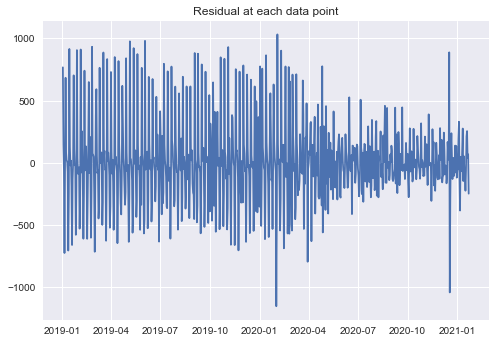

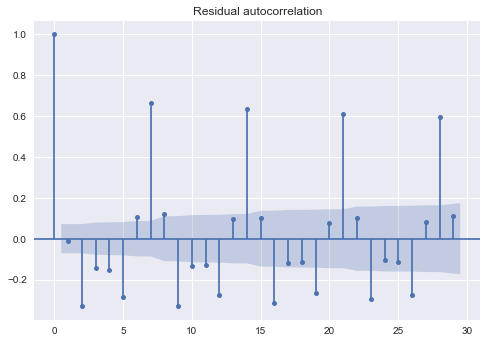

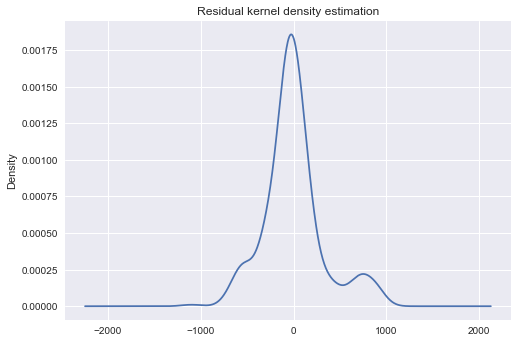

                  0
count  7.520000e+02
mean  -5.102302e-15
std    3.246498e+02
min   -1.151996e+03
25%   -1.532654e+02
50%   -2.550764e+01
75%    1.069077e+02
max    1.032125e+03
p value is  2.4468820290486804e-15
null hypothesis: residuals comes from a normal distribution
The null hypothesis can be rejected


In [41]:
P=0
D=1
Q=0

# fit model
N= 753  
model = ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit(disp = 0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# plt.figure(figsize = (6,4))
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals comes from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [42]:
model_fit.aic

10834.33426791893

Text(0, 0.5, 'Proportion')

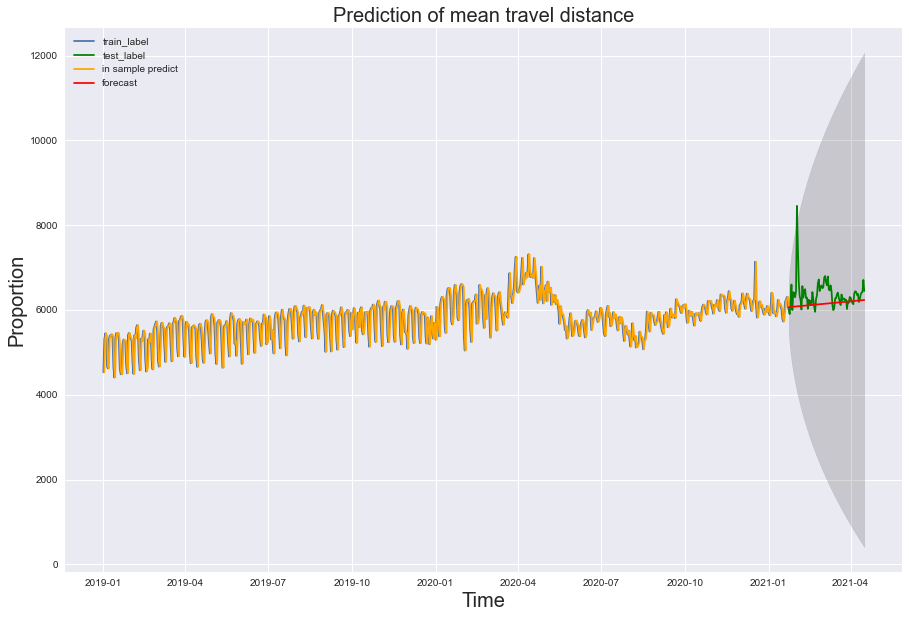

In [43]:
forecast = model_fit.forecast(steps=len(series)-N, alpha=0.05)[0]  # 95% conf
# Forecast
fc, se, conf = model_fit.forecast(steps=len(series)-N, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=range(N,len(series)))
lower_series = pd.Series(conf[:, 0], index=range(N,len(series)))
upper_series = pd.Series(conf[:, 1], index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(15,10)})
# plt.plot(series)

# plt.plot(series)
plt.plot(df_t.index[:N+1],series[:N+1],label='train_label')
plt.plot(df_t.index[N:],series[N:],color='green',label='test_label')
plt.plot(df_t.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),color='orange',label='in sample predict')
plt.plot(df_t.iloc[N:].index,fc_series.tolist(), label='forecast', color='red')
plt.fill_between(df_t.iloc[N:].index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left')
plt.title("Prediction of mean travel distance", fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Proportion', fontsize=20)

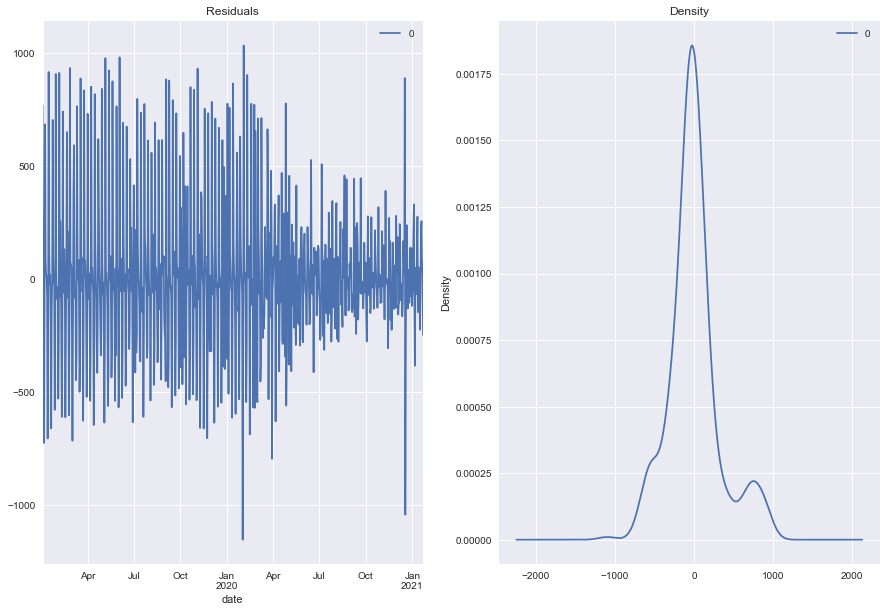

In [44]:
##Check the residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


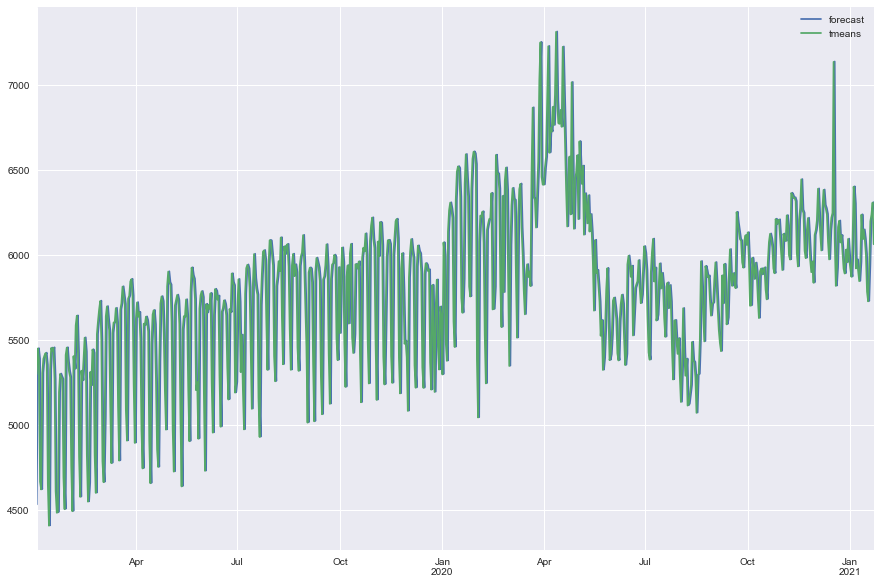

In [45]:
## bar chart
model_fit.plot_predict(dynamic=False)
plt.show()

## Dwell Home Time

In [46]:
df_h = dfnew[['mean_home_dwell_time'
              ,'home_dwell_time:<60'
              ,'home_dwell_time:61-360'
              ,'home_dwell_time:361-720'
              ,'home_dwell_time:721-1080'
              ,'home_dwell_time:>1080']]
df_h.describe()

mean_home_dwell_time  home_dwell_time:<60  home_dwell_time:61-360  \
count          8.370000e+02           837.000000              837.000000   
mean           3.619635e+06         91811.902031            50917.097969   
std            1.584703e+06         26410.311928            19995.472262   
min            0.000000e+00         34664.000000            21459.000000   
25%            3.844694e+06         71812.000000            34618.000000   
50%            4.193812e+06         82199.000000            41502.000000   
75%            4.512331e+06        114147.000000            67336.000000   
max            5.256719e+06        171224.000000           100772.000000   

       home_dwell_time:361-720  home_dwell_time:721-1080  \
count               837.000000                837.000000   
mean              57037.015532              65395.267622   
std               27647.545054              25075.016308   
min               19204.000000              19268.000000   
25%               32485.000000              42270.000000   
50%               45414.000000              62665.000000   
75%               81550.000000              89331.000000   
max              120397.000000             114951.000000   

       home_dwell_time:>1080  
count             837.000000  
mean            98813.371565  
std             24877.429760  
min             46657.000000  
25%             79482.000000  
50%             98317.000000  
75%            113907.000000  
max            204256.000000

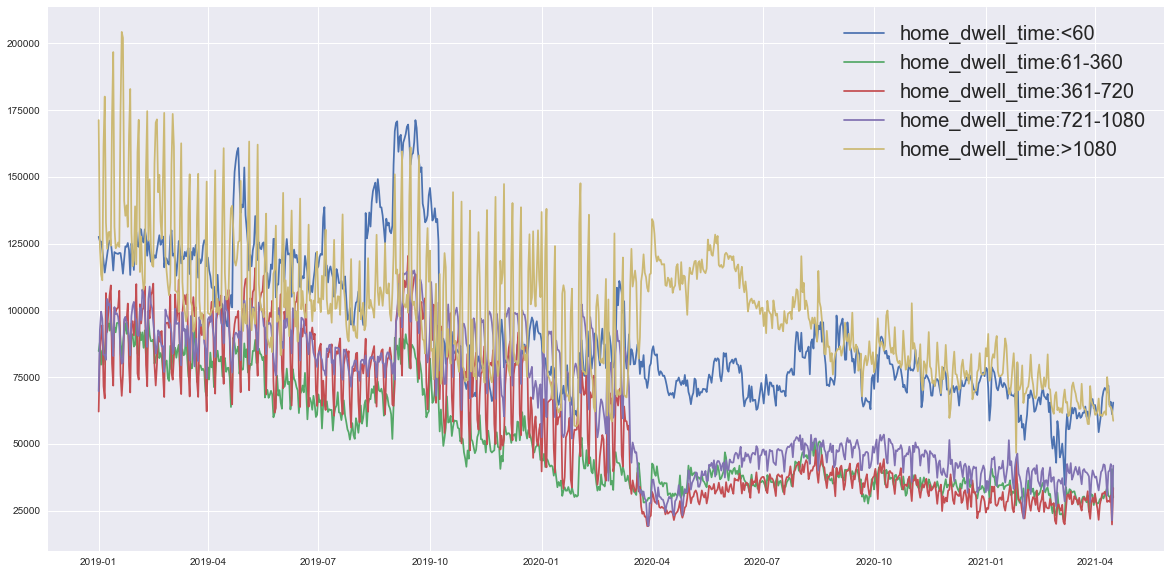

In [47]:
plt.figure(figsize=(20,10))
plt.style.use('seaborn')
plt.plot(df_h[['home_dwell_time:<60'
              ,'home_dwell_time:61-360'
              ,'home_dwell_time:361-720'
              ,'home_dwell_time:721-1080'
              ,'home_dwell_time:>1080']])
plt.legend(['home_dwell_time:<60'
              ,'home_dwell_time:61-360'
              ,'home_dwell_time:361-720'
              ,'home_dwell_time:721-1080'
              ,'home_dwell_time:>1080'],fontsize=20)

Text(0.5, 1.0, 'Home dwell time count(moving average = 30)')

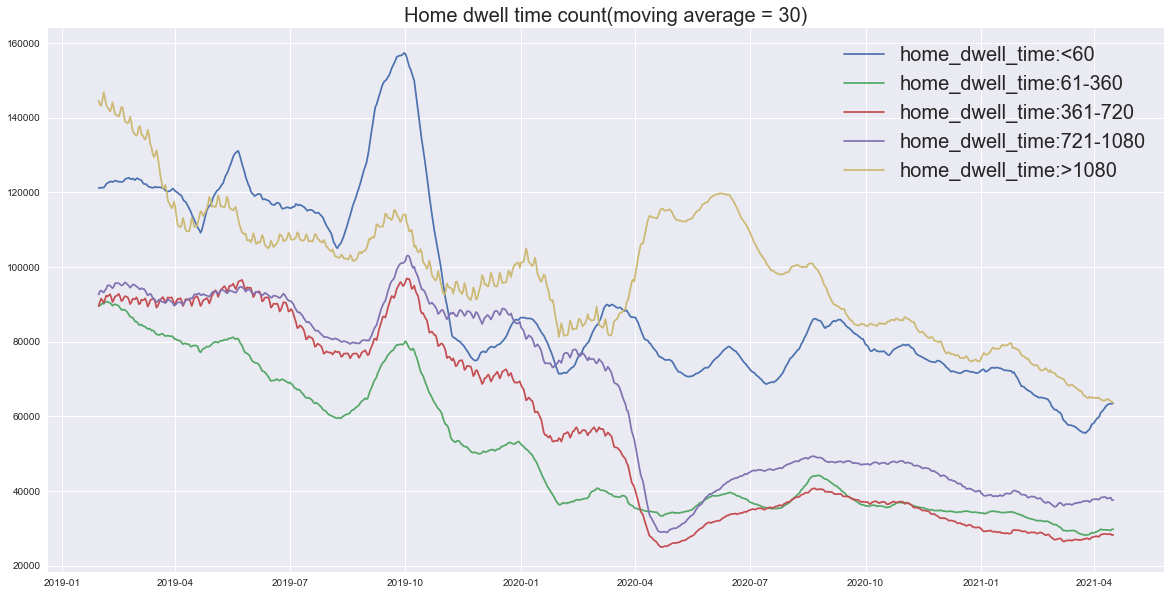

In [48]:
plt.figure(figsize=(20,10))
plt.style.use('seaborn')
plt.plot(df_h[['home_dwell_time:<60'
              ,'home_dwell_time:61-360'
              ,'home_dwell_time:361-720'
              ,'home_dwell_time:721-1080'
              ,'home_dwell_time:>1080']].rolling(window=30).mean())
plt.legend(['home_dwell_time:<60'
              ,'home_dwell_time:61-360'
              ,'home_dwell_time:361-720'
              ,'home_dwell_time:721-1080'
              ,'home_dwell_time:>1080'],fontsize=20)
plt.title("Home dwell time count(moving average = 30)", fontsize=20)

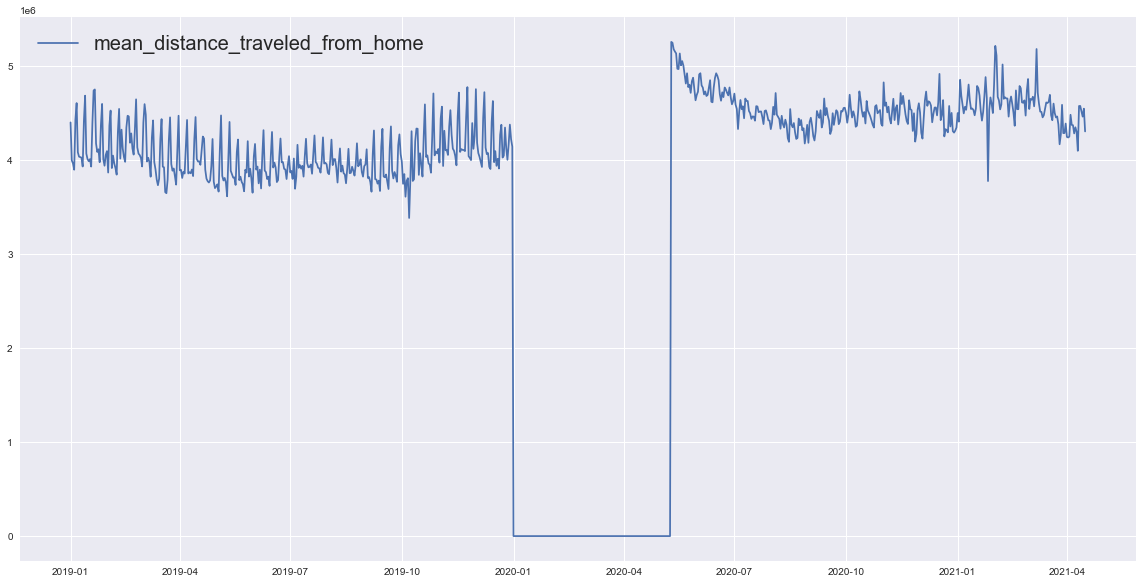

In [49]:
plt.figure(figsize=(20,10))
plt.plot(df_h['mean_home_dwell_time'])
plt.legend(['mean_distance_traveled_from_home'],fontsize=20)

In [50]:
ff1 = []
ffm1 = df_h['home_dwell_time:61-360']*210+df_h['home_dwell_time:361-720']*540+df_h['home_dwell_time:721-1080']*900+df_h['home_dwell_time:>1080']*1440
ffd1 = df_h['home_dwell_time:<60']+df_h['home_dwell_time:61-360']+df_h['home_dwell_time:361-720']+df_h['home_dwell_time:721-1080']+df_h['home_dwell_time:>1080']
ff1 = ffm1/ffd1
df_h[['hmeans']] = ff1
df_h

mean_home_dwell_time  home_dwell_time:<60  home_dwell_time:61-360  \
date                                                                            
2019-01-01             4400074.0             127518.0                 84730.0   
2019-01-02             3996661.0             125934.0                 88140.0   
2019-01-03             3963868.0             125746.0                 79620.0   
2019-01-04             3897095.0             122705.0                 84959.0   
2019-01-05             4427800.0             118305.0                 79688.0   
...                          ...                  ...                     ...   
2021-04-12             4575311.0              71812.0                 30558.0   
2021-04-13             4518380.0              64559.0                 30170.0   
2021-04-14             4462034.0              65731.0                 29304.0   
2021-04-15             4546690.0              61105.0                 40521.0   
2021-04-16             4304721.0              65457.0                 29922.0   

            home_dwell_time:361-720  home_dwell_time:721-1080  \
date                                                            
2019-01-01                  62086.0                   69723.0   
2019-01-02                  85161.0                   92769.0   
2019-01-03                  90646.0                   99520.0   
2019-01-04                  94460.0                   96773.0   
2019-01-05                  71600.0                   83388.0   
...                             ...                       ...   
2021-04-12                  28680.0                   39528.0   
2021-04-13                  28317.0                   40038.0   
2021-04-14                  30663.0                   42429.0   
2021-04-15                  19813.0                   21359.0   
2021-04-16                  33483.0                   41838.0   

            home_dwell_time:>1080      hmeans  
date                                           
2019-01-01               171232.0  699.887869  
2019-01-02               123708.0  632.383889  
2019-01-03               113460.0  625.981233  
2019-01-04               111242.0  619.701630  
2019-01-05               161510.0  705.594617  
...                           ...         ...  
2021-04-12                70042.0  658.050287  
2021-04-13                63971.0  659.660963  
2021-04-14                63865.0  658.917376  
2021-04-15                62574.0  625.879331  
2021-04-16                58640.0  638.616203  

[837 rows x 7 columns]

Text(0.5, 1.0, 'Mean home dwell time')

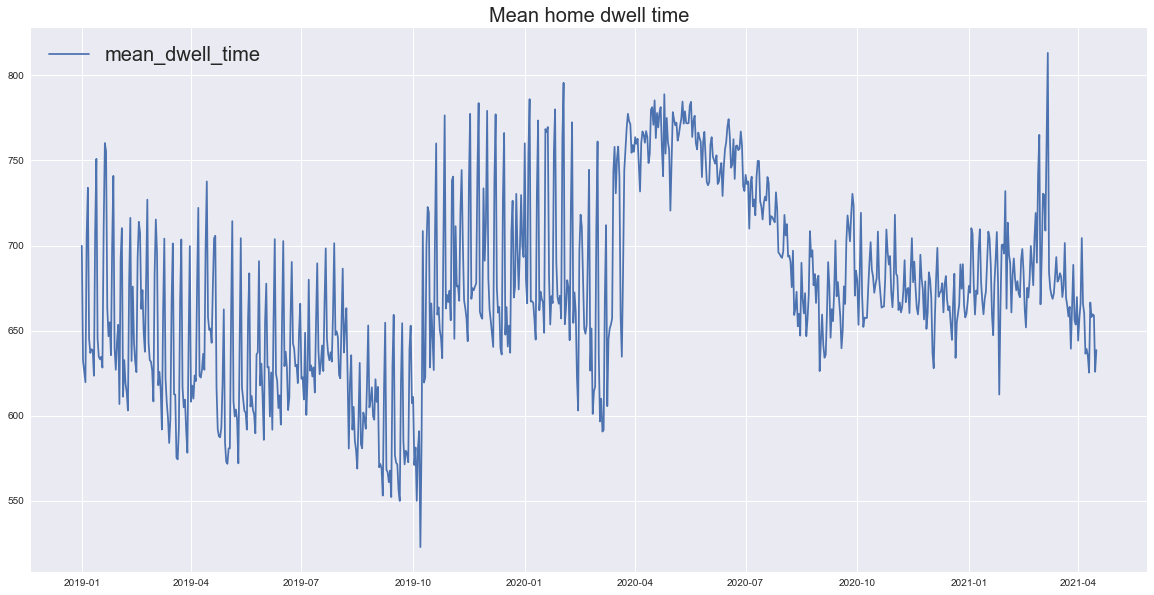

In [51]:
plt.figure(figsize=(20,10))
plt.plot(df_h['hmeans'])
plt.legend(['mean_dwell_time'],fontsize=20)
plt.title("Mean home dwell time", fontsize=20)

Text(0.5, 1.0, 'Mean home dwell time(moving average = 30)')

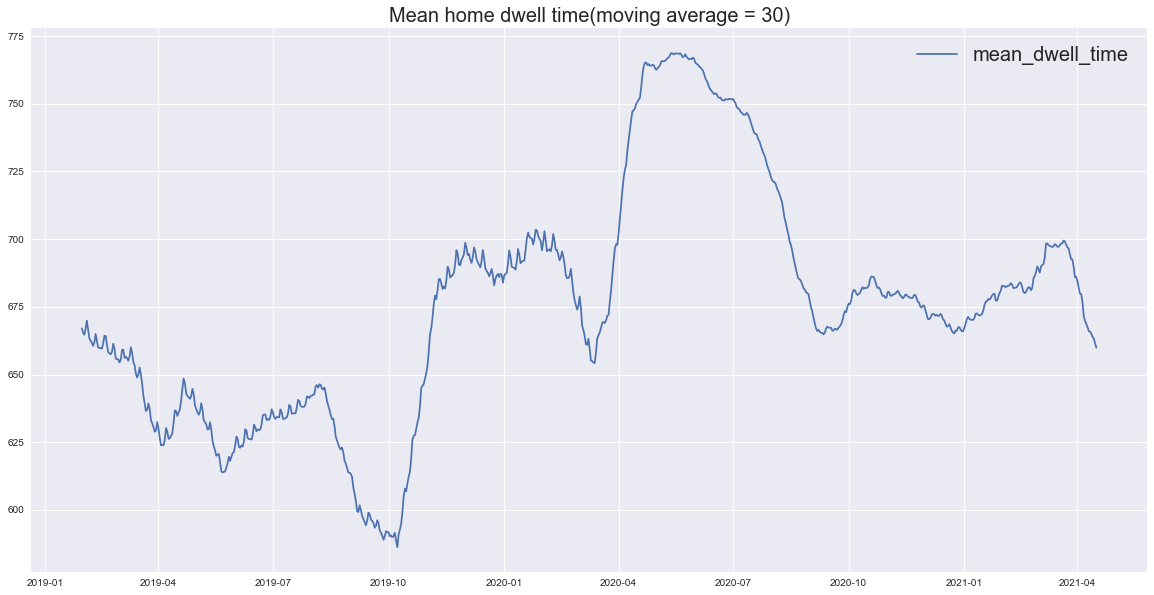

In [52]:
plt.figure(figsize=(20,10))
plt.plot(df_h['hmeans'].rolling(window=30).mean())
plt.legend(['mean_dwell_time'],fontsize=20)
plt.title("Mean home dwell time(moving average = 30)", fontsize=20)

In [53]:
#0 differencing
series=df_h['hmeans']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.006093
p-value: 0.283908
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [54]:
#reaches the stationarity after first differencing
result = adfuller(series.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.938987
p-value: 0.000000


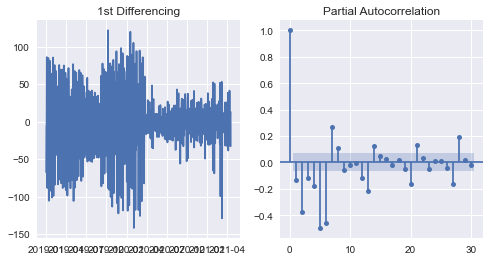

In [55]:
#AR
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].plot(series.diff())
axes[0].set_title('1st Differencing')

plot_pacf(series.diff().dropna(), ax=axes[1])

plt.show()

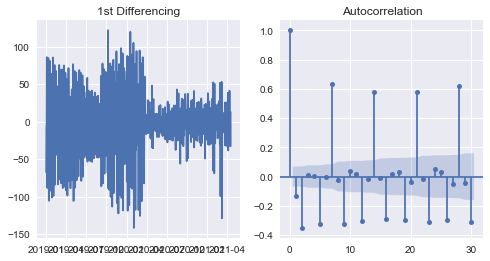

In [56]:
#MA
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].plot(series.diff()); axes[0].set_title('1st Differencing')
plot_acf(series.diff().dropna(), ax=axes[1],alpha=0.05)

plt.show()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                              ARMA Model Results                              
Dep. Variable:                 hmeans   No. Observations:                  753
Model:                     ARMA(8, 2)   Log Likelihood               -3464.280
Method:                       css-mle   S.D. of innovations             23.977
Date:                Mon, 03 May 2021   AIC                           6952.560
Time:                        14:50:44   BIC                           7008.049
Sample:                    01-01-2019   HQIC                          6973.937
                         - 01-22-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          674.3740     17.145     39.333      0.000     640.770     707.978
ar.L1.hmeans     0.1257      0.041      3.049      0.002       0.045       0.207
ar.L2.hmeans    -0.5047      0.037    -13.55

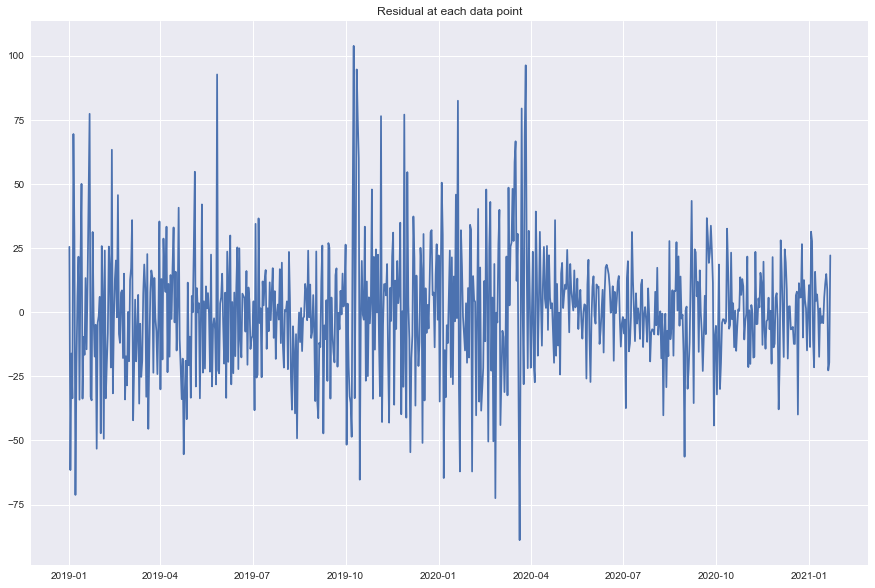

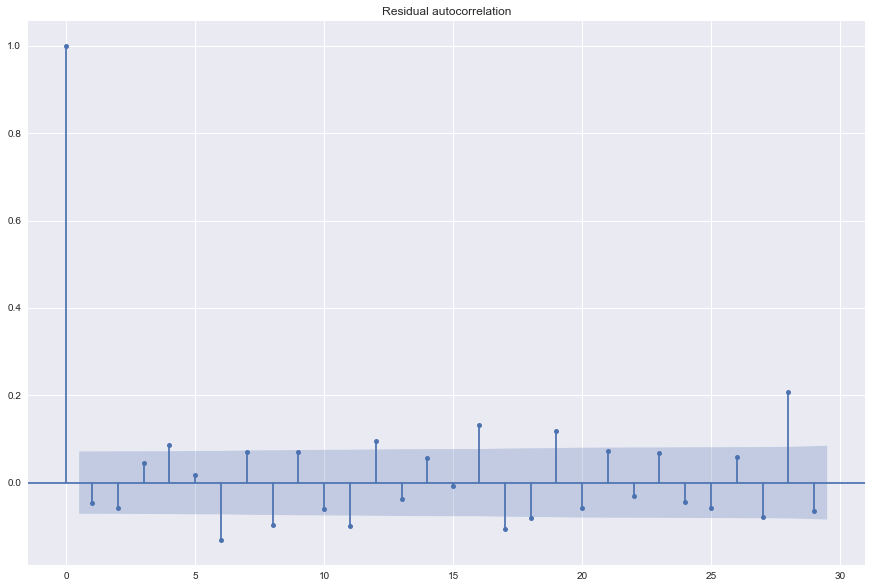

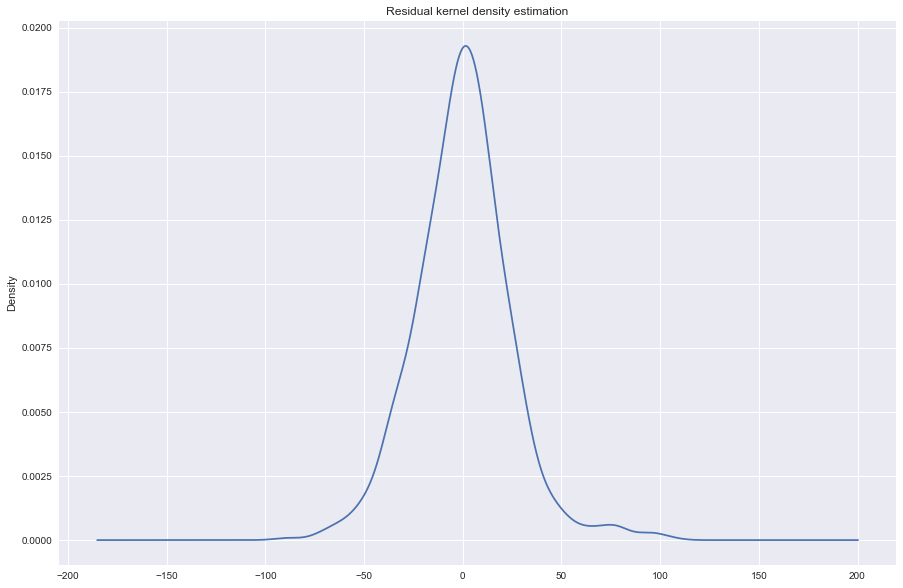

                0
count  753.000000
mean     0.013704
std     24.228903
min    -88.855350
25%    -14.553988
50%     -0.002194
75%     12.959855
max    103.884676
p value is  8.35246211109383e-12
null hypothesis: residuals comes from a normal distribution
The null hypothesis can be rejected


In [99]:
P=2
D=0
Q=8

# fit model
N= 753  
model = ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit(disp = 0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# plt.figure(figsize = (6,4))
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals comes from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [100]:
model_fit.aic

6952.560111190978

Text(0.5, 1.0, 'Prediction of mean home dwell time')

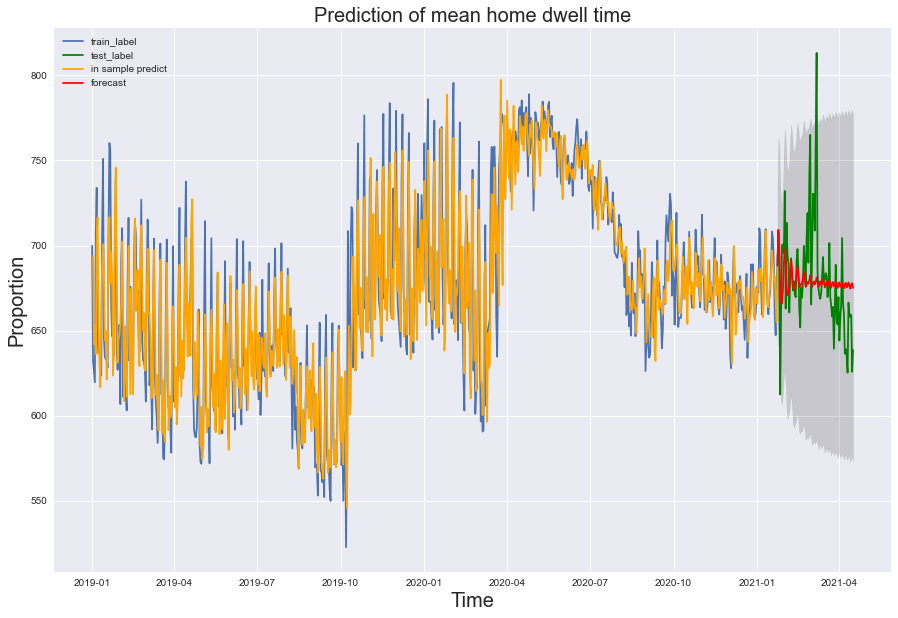

In [101]:
forecast = model_fit.forecast(steps=len(series)-N, alpha=0.05)[0]  # 95% conf
# Forecast
fc, se, conf = model_fit.forecast(steps=len(series)-N, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=range(N,len(series)))
lower_series = pd.Series(conf[:, 0], index=range(N,len(series)))
upper_series = pd.Series(conf[:, 1], index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(15,10)})
# plt.plot(series)

# plt.plot(series)
plt.plot(df_h.index[:N+1],series[:N+1],label='train_label')
plt.plot(df_h.index[N:],series[N:],color='green',label='test_label')
plt.plot(df_h.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),color='orange',label='in sample predict')
plt.plot(df_h.iloc[N:].index,fc_series.tolist(), label='forecast', color='red')
plt.fill_between(df_h.iloc[N:].index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left')
plt.title("Prediction of positive/neutral", fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.title("Prediction of mean home dwell time", fontsize=20)

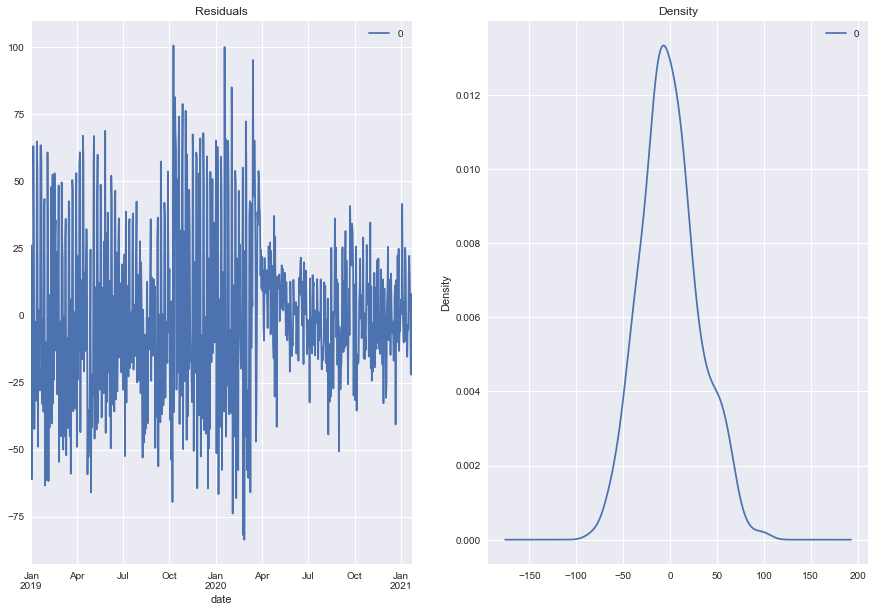

In [95]:
##Check the residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


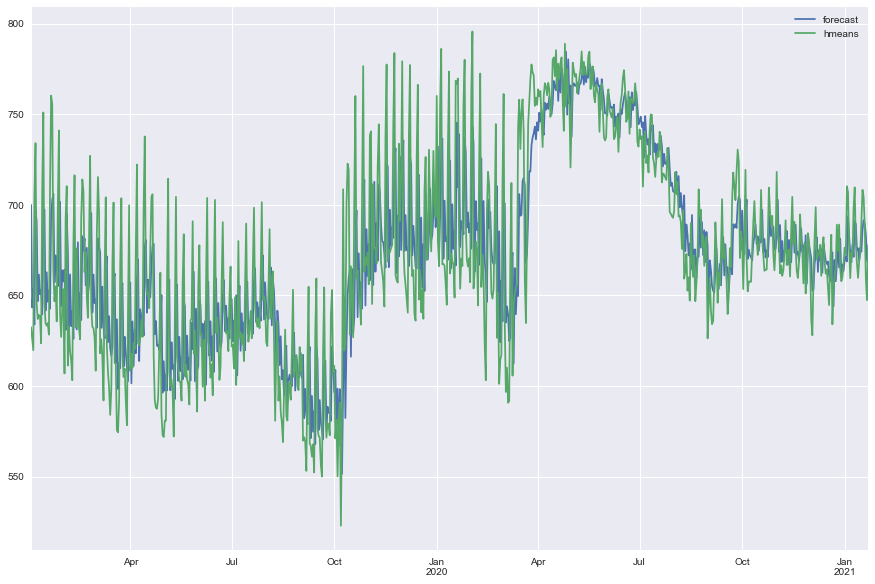

In [61]:
## bar chart
model_fit.plot_predict(dynamic=False)
plt.show()